# Spatial data Preprocessing

In [1]:
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import momepy
import networkx as nx
from tqdm.notebook import tqdm

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## 고도 데이터

<Axes: >

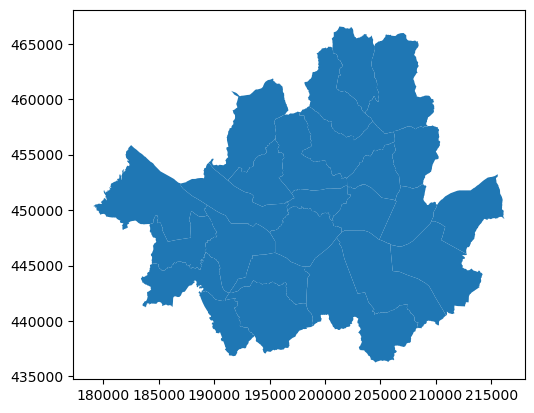

In [2]:
# Seoul area

seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)
seoul.plot()

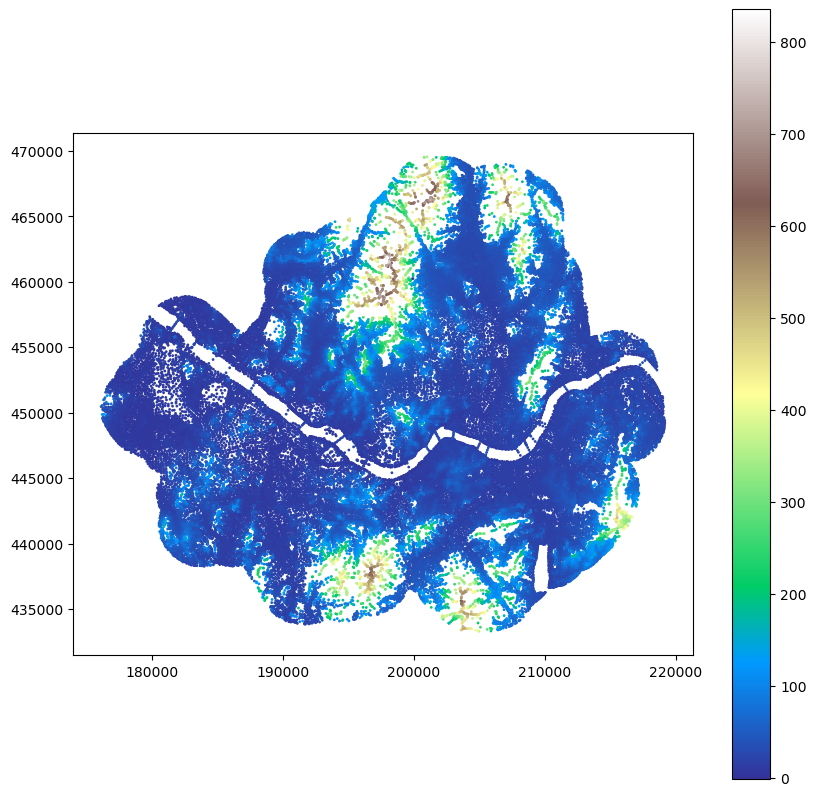

In [3]:
# Load the data
elevation = gpd.read_file('data/elevation/표고 5000/N3P_F002.shp') # crs 5174

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

elevation.plot(column='HEIGHT', ax=ax, legend=True, cmap='terrain', markersize=1)
plt.show() ## 그대로 사용하면 될듯

# 교통량 데이터

In [32]:
roads = gpd.read_file('data/seoul_road/Z_KAIS_TL_SPRD_MANAGE_11.shp', encoding='euc-kr', crs='epsg:5179')
roads = roads.to_crs('epsg:5174')
roads = roads[roads.ROA_CLS_SE.isin(['1','2','3'])]

In [56]:
selected_GU = ['강남구', '서초구', '동작구', '관악구', '송파구']
selected_GU = ['서울특별시 ' + gu for gu in selected_GU]

seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)
seoul_selected = seoul[seoul.SGG_NM.isin(selected_GU)]

In [77]:
roads_selected = gpd.sjoin(roads, seoul_selected, how='left', predicate='intersects').reset_index(drop=True)
roads_selected = roads_selected[['RN', 'geometry']].explode().reset_index(drop=True)
roads_selected

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_69384/2223912570.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  roads_selected = roads_selected[['RN', 'geometry']].explode().reset_index(drop=True)


,RN,geometry
0,한천로,"LINESTRING (205057.521 456982.902, 205054.086 ..."
1,용마공원로,"LINESTRING (208880.447 454615.840, 208875.306 ..."
2,망우로,"LINESTRING (205121.742 454090.416, 205100.672 ..."
3,장위로,"LINESTRING (204538.854 456841.191, 204540.432 ..."
4,서울시립대로,"LINESTRING (204119.427 452620.559, 204056.601 ..."
...,...,...
9143,사평지하도로,"LINESTRING (199934.016 444282.672, 199994.757 ..."
9144,강남터미널고가도로,"LINESTRING (200172.250 444525.234, 200150.936 ..."
9145,염곡지하도로,"LINESTRING (203964.978 440134.243, 203941.892 ..."
9146,염곡동서지하도로,"LINESTRING (203483.449 440165.804, 203527.340 ..."


In [78]:
# momepy

ntw = momepy.gdf_to_nx(roads_selected, approach='primal')

In [79]:
nx.floyd_warshall_numpy(ntw, weight='mm_len')

KeyboardInterrupt: 

In [5]:
# 서울시 교통량 조사자료

traffic = pd.read_excel('data/traffic/04월 서울시 교통량 조사자료(2024).xlsx', sheet_name='2024년 04월')
traffic_info = pd.read_excel('data/traffic/04월 서울시 교통량 조사자료(2024).xlsx', sheet_name='수집지점 주소 및 좌표', skipfooter=4, usecols='A:E')
traffic_info = gpd.GeoDataFrame(traffic_info, geometry=gpd.points_from_xy(traffic_info['경도'], traffic_info['위도']), crs='wgs84')
traffic_info.to_crs(epsg=5174, inplace=True)

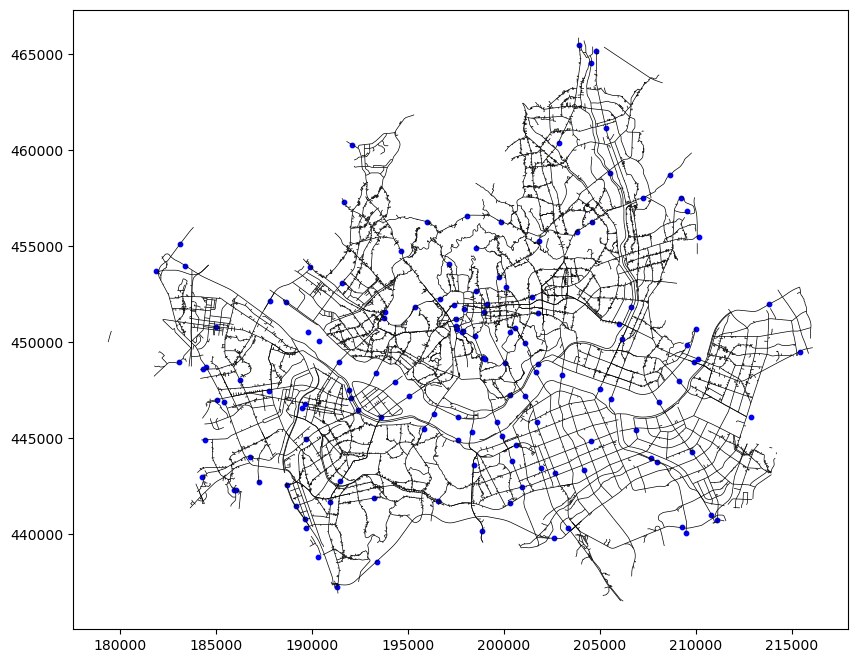

In [30]:
roads = gpd.read_file('data/seoul_road/seoul_road.shp')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
roads.plot(ax=ax, color='black', linewidth=0.5)
# traffic_info[traffic_info.지점명칭.str.contains('대교')].plot(ax=ax, color='red', markersize=10)
traffic_info.plot(ax=ax, color='blue', markersize=10)
plt.show()

In [7]:
# roads.to_file('data/seoul_road/seoul_road.shp')

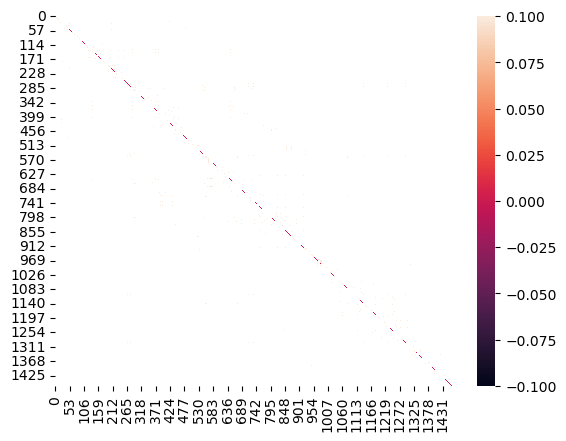

In [8]:
# Load matrix

shortest_matrix = np.load('data/traffic/shortest_path.npy')

# Plot

import seaborn as sns

sns.heatmap(shortest_matrix)
plt.show()

In [9]:
# count inf
np.sum(np.isinf(shortest_matrix))

len(shortest_matrix)

1466

# 차량통행속도 데이터

In [11]:
# Combine July, August, September

speed07 = pd.read_csv('data/traffic/202307.csv')
speed08 = pd.read_csv('data/traffic/202308.csv')
speed09 = pd.read_csv('data/traffic/202309.csv')

speed = pd.concat([speed07, speed08, speed09])

# 01시 - 24시
id_vars = ['일자', '링크아이디']
hour_idx = [f'{i:02}시' for i in range(1, 25)]

In [12]:
speed_long = speed.melt(id_vars=id_vars, value_vars=hour_idx, var_name='hour', value_name='speed')
speed_long.columns = ['date', 'LINK_ID', 'hour', 'speed']
speed_long = speed_long.pivot(index = ['date', 'hour'], columns='LINK_ID', values='speed')
speed_long.reset_index(inplace=True)
# date, hour to datetime
speed_long['datetime'] = pd.to_datetime(speed_long['date'], format='%Y%m%d') + pd.to_timedelta(speed_long['hour'].str.replace('시', '').astype(int), unit='h')
speed_long.drop(columns=['date', 'hour'], inplace=True)
speed_long.set_index('datetime', inplace=True)
speed_long.to_csv('data/traffic/speed_long.csv')
speed_long.head()

In [13]:
# count nam

speed_long = pd.read_csv('data/traffic/speed_long.csv')

speed_long.dropna(axis=1, how='any', inplace=True)
speed_long.to_csv('data/traffic/speed_long.csv', index=False)

In [14]:
speed_long = pd.read_csv('data/traffic/speed_long.csv')

In [34]:
link = pd.read_excel('data/traffic/link.xlsx')
link = gpd.GeoDataFrame(link, geometry=gpd.points_from_xy(link['GRS80TM_X'], link['GRS80TM_Y']), crs='epsg:5174')

# to int
available_links = speed_long.columns[1:-1].astype(int)
available_links

# Select link where speed data is available

link = link[link['LINK_ID'].isin(available_links)]
link.shape

(29430, 5)

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_69384/3044387456.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  roads.groupby('RN_CD', as_index=False).geometry.apply(lambda x: x.unary_union).explode().reset_index().plot()


<Axes: >

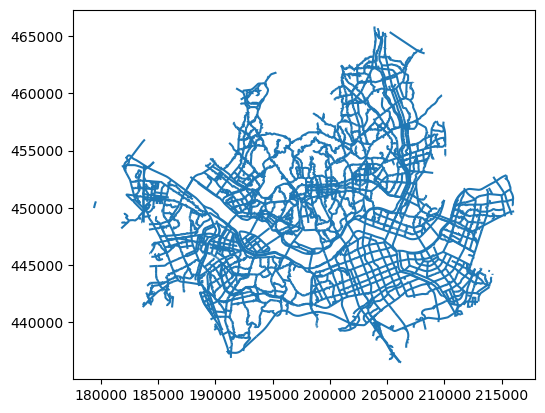

In [55]:
roads.groupby('RN_CD', as_index=False).geometry.apply(lambda x: x.unary_union).explode().reset_index()

In [40]:
roads.RN

1              한천로
5            용마공원로
11             망우로
12             장위로
32          서울시립대로
           ...    
66947       사평지하도로
66948    강남터미널고가도로
66949       염곡지하도로
66950     염곡동서지하도로
66951     염곡동서지하도로
Name: RN, Length: 9070, dtype: object

In [44]:
pd.read_excel('data/traffic/서울시 서비스링크 정보_2024년3월 기준.xlsx').도로명.isin(roads.RN).value_counts()

도로명
True     4723
False     385
Name: count, dtype: int64

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_69384/876539446.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()


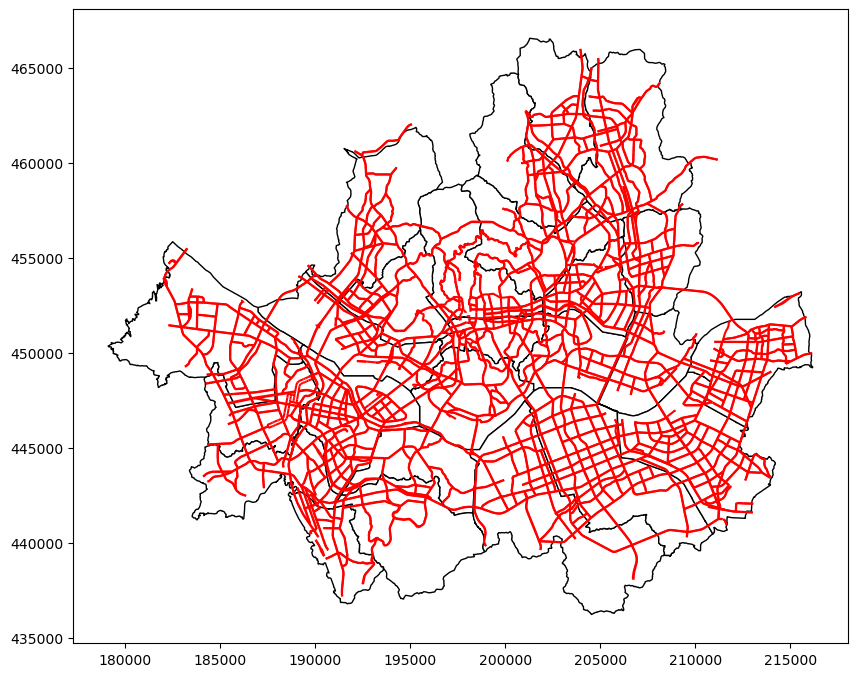

In [16]:
# Groupby LINK_ID and calculate the centroid of each link
from shapely.geometry import LineString

link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()
link_line.columns = ['LINK_ID', 'geometry']
link_line = gpd.GeoDataFrame(link_line, crs='epsg:5174')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

seoul.plot(ax=ax, color='white', edgecolor='black')
link_line.plot(ax=ax, color='red', markersize=1)
plt.show()

In [25]:
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import momepy
import networkx as nx
from shapely.geometry import LineString

# Seoul area

selected_GU = ['강남구', '서초구', '동작구', '관악구', '송파구']
selected_GU = ['서울특별시 ' + gu for gu in selected_GU]

seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)
seoul_selected = seoul[seoul.SGG_NM.isin(selected_GU)]

elevation = gpd.read_file('data/elevation/표고 5000/N3P_F002.shp') # crs 5174
# select intersects with seoul_selected
elevation = gpd.sjoin(elevation, seoul_selected)

speed_long = pd.read_csv('data/traffic/speed_long.csv') # speed data

link = pd.read_excel('data/traffic/link.xlsx')
link = gpd.GeoDataFrame(link, geometry=gpd.points_from_xy(link['GRS80TM_X'], link['GRS80TM_Y']), crs='epsg:5174')

# to int
available_links = speed_long.columns[1:-1].astype(int)

# Select link where speed data is available
# link = link[link['LINK_ID'].isin(available_links)]
link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()
link_line.columns = ['LINK_ID', 'geometry']
link_line = gpd.GeoDataFrame(link_line, crs='epsg:5174')
link_line = gpd.sjoin(link_line, seoul_selected)
print(link_line.shape)

# Momepy
ntw = momepy.gdf_to_nx(link_line)
print('networkx object created')

shortest_path = nx.floyd_warshall_numpy(ntw, weight='mm_len')

np.save('data/traffic/shortest_path.npy', shortest_path)

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_69384/1668526908.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()


(1222, 7)
networkx object created


In [112]:
# Python3 샘플 코드 #

import requests
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = "https://www.safetydata.go.kr"
dataName = "/V2/api/DSSP-IF-00117"
serviceKey = "5YYYJ7R39394D5GK"
payloads = {
    "serviceKey": serviceKey,
    "returnType": "json",
    "pageNo": "50",
    "numOfRows": "1000",
}

response = requests.get(url + dataName, params=payloads)

In [120]:
# # Python3 샘플 코드 #

# import requests
# import urllib3

# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# result = []

# for i in range(1,14):
#     url = "https://www.safetydata.go.kr"
#     dataName = "/V2/api/DSSP-IF-00117"
#     serviceKey = "5YYYJ7R39394D5GK"
#     payloads = {
#         "serviceKey": serviceKey,
#         "returnType": "json",
#         "pageNo": str(i),
#         "numOfRows": "1000",
#     }

#     response = requests.get(url + dataName, params=payloads)
#     result.append(response.json())

In [124]:
# Result cleaning

import pandas as pd

res = []
for r in result:
    res.extend(r['body'])

In [129]:
# TO DataFrame

df = pd.DataFrame(res)
df.to_csv('data/flood/flood.csv', index=False)

In [199]:
# 서울시 격자화

seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)

xmin, ymin, xmax, ymax = seoul.total_bounds

cell_size = 100 # 100m x 100m

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), cell_size))

rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), cell_size))

rows.reverse()

polygons = []


for x in cols:
    for y in rows:
        polygons.append(shapely.geometry.box(x, y, x+cell_size, y+cell_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs='epsg:5174')

# Take only the grid that intersects with seoul

grid = gpd.sjoin(grid, seoul, how='inner', predicate='intersects')
grid.drop(columns='index_right', inplace=True)

grid.to_pickle('data/grid.pkl')

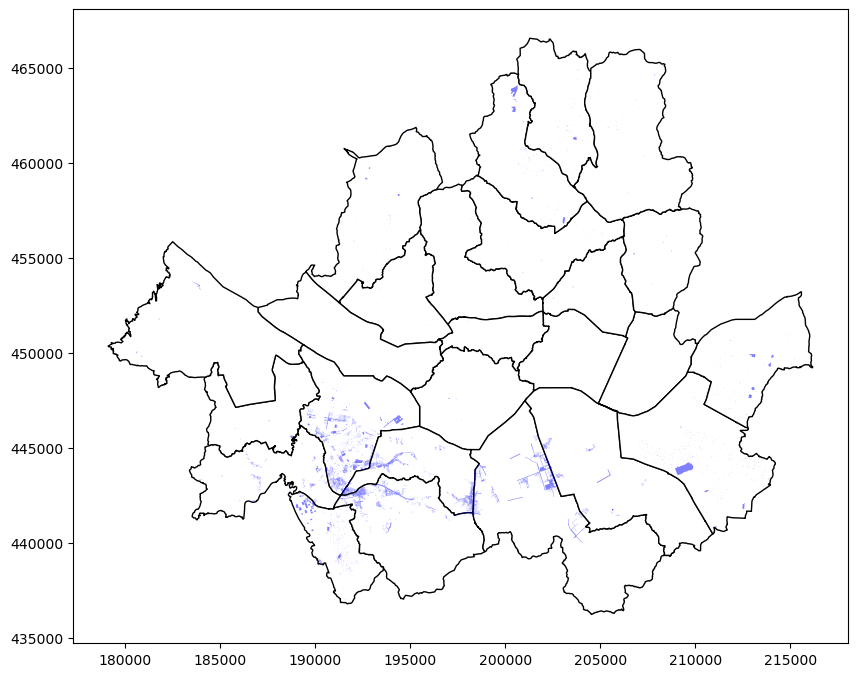

In [202]:
# Flood data
grid = pd.read_pickle('data/grid.pkl')
flood = gpd.read_file('data/flood/서울시_2022.shp').to_crs(epsg=5174)

# plot

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
seoul.plot(ax=ax, color='white', edgecolor='black')
flood.plot(ax=ax, color='blue', alpha=0.5)
plt.show()

In [206]:
# Spatial join flood data with grid

flood_grid = gpd.sjoin(flood, grid, how='left')
grid['flood'] = flood_grid.groupby('index_right').size()
grid['flood'] = grid['flood'].fillna(0)

grid.to_pickle('data/grid.pkl')

In [209]:
# 상가 오피스텔 데이터
from tqdm.notebook import tqdm

grid = pd.read_pickle('data/grid.pkl')

In [2]:
office = gpd.read_file('data/상가오피스텔/sopsrt_oftl_seoul.shp').to_crs(epsg=5174)

In [ ]:
categories = office.cmsc_l_nm.unique()
print(categories)

In [211]:
# Count the number of each cmsc_l_nm (상권업종대분류명) for each grid
categories = office.cmsc_l_nm.unique()

for i, category in enumerate(tqdm(categories)):
    office_category = office[office.cmsc_l_nm == category]
    office_category_grid = gpd.sjoin(office_category, grid, how='left')
    grid[f'office_cat_{i}'] = office_category_grid.groupby('index_right').size()
    grid[f'office_cat_{i}'] = grid[f'office_cat_{i}'].fillna(0)

grid.to_pickle('data/grid.pkl')

print(grid.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

(64738, 16)


In [220]:
# 평균고도

elevation = gpd.read_file('data/elevation/표고 5000/N3P_F002.shp') # crs 5174

# For each grid cell, calculate the average elevation

elevation_grid = gpd.sjoin(elevation, grid, how='left')
grid['elevation'] = elevation_grid.groupby('index_right')['HEIGHT'].mean()

grid.to_pickle('data/grid.pkl')

In [235]:
# RAINPUMP data
## For each grid cell, calculate the distance to the nearest rain pump

rainpump = gpd.read_file('data/RAINPUMP/RAINPUMP.shp')
rainpump.crs = 'epsg:5186'
rainpump = rainpump.to_crs('epsg:5174')

grid['rainpump'] = np.nan

for i, row in tqdm(grid.iterrows(), total=grid.shape[0]):
    distance = rainpump.distance(row['geometry'])
    grid.at[i, 'rainpump'] = distance.min()

grid.to_pickle('data/grid.pkl')

  0%|          | 0/64738 [00:00<?, ?it/s]

In [12]:
# 가로수 위치정보

import requests
import bs4
from tqdm.notebook import tqdm
import xmltodict

seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)

key = '7863635a6264616e38357843466975'
GGs = seoul.SGG_NM.str.split(' ').str[1]


for gu in tqdm(GGs):
    url = f'http://openAPI.seoul.go.kr:8088/{key}/xml/GeoInfoOfRoadsideTreeW/1/5/{gu}'
    response = requests.get(url)
    data = xmltodict.parse(response.text)
    try:
        length_gu = int(data['GeoInfoOfRoadsideTreeW']['list_total_count'])
    except:
        continue

    result = []

    for i in range(1, length_gu+1, 1000):
        url = f'http://openAPI.seoul.go.kr:8088/{key}/xml/GeoInfoOfRoadsideTreeW/{i}/{i+999}/{gu}'
        response = requests.get(url)
        xml_obj = bs4.BeautifulSoup(response.text, 'lxml-xml')
        data = xml_obj.find_all('row')

        for d in data:
            row_data = {tag.name: tag.text for tag in d.find_all()}
            result.append(row_data)

    df = pd.DataFrame(result)
    df.to_csv(f'data/가로수/{gu}.csv', index=False)

  0%|          | 0/25 [00:00<?, ?it/s]

In [34]:
# 가로수 위치정보

grid = pd.read_pickle('data/grid.pkl')

li = []

for gu in tqdm(GGs):
    try:
        df = pd.read_csv(f'data/가로수/{gu}.csv')
        li.append(df)
    except:
        continue

trees = pd.concat(li)

# Replace non-numeric values with NaN
trees['LNG'] = pd.to_numeric(trees['LNG'], errors='coerce')
trees['LAT'] = pd.to_numeric(trees['LAT'], errors='coerce')

# Remove rows with NaN values in 'LNG' or 'LAT' column
trees = trees.dropna(subset=['LNG', 'LAT'])

trees = gpd.GeoDataFrame(trees, geometry=gpd.points_from_xy(trees['LNG'], trees['LAT']))
trees.crs = 'WGS1984'
trees = trees.to_crs('epsg:5174')

# Count the number of trees in each grid cell

trees_grid = gpd.sjoin(trees, grid, how='left')
grid['trees'] = trees_grid.groupby('index_right').size()
grid['trees'] = grid['trees'].fillna(0)

grid.to_pickle('data/grid.pkl')

  0%|          | 0/25 [00:00<?, ?it/s]

In [50]:
trashcan

,연번,자치구명,설치위치(도로명 주소),세부 위치,설치 장소 유형,수거 쓰레기 종류
0,1,종로구,사직로 125,경복궁역 4번출구,지하철역 입구,일반쓰레기
1,2,종로구,사직로 125,경복궁역 4번출구,지하철역 입구,재활용쓰레기
2,3,종로구,자하문로 28,스타벅스 앞,도로변(횡단보도 포함),일반쓰레기
3,4,종로구,자하문로 28,스타벅스 앞,도로변(횡단보도 포함),재활용쓰레기
4,5,종로구,자하문로 44,라파리나 카페 앞,도로변(횡단보도 포함),일반쓰레기
...,...,...,...,...,...,...
5375,5376,강동구,명일동 60,한영중고한영외고 맞은편(25-180),"정류소(버스,택시 등)",일반쓰레기
5376,5377,강동구,고덕로 269,고덕역 3번 출구(명덕성결교회 입구 부근),지하철역 입구,일반쓰레기
5377,5378,강동구,고덕동 313-1,배재중고등학교(25-141)(배재고등학교정문 옆),"정류소(버스,택시 등)",일반쓰레기
5378,5379,강동구,상일동 440-3,상일초교(중)(25-001),"정류소(버스,택시 등)",일반쓰레기


In [ ]:
# 실폭도로 데이터 > area of road for each grid cell

roads = gpd.read_file('data/seoul_road/실폭도로/TL_SPRD_RW_11.shp').to_crs(epsg=5174)

grid['road_area'] = np.nan

for i, row in tqdm(grid.iterrows(), total=grid.shape[0]):
    try:
        area = roads.intersection(row['geometry']).area.sum()
        grid.at[i, 'road_area'] = area
    except:
        print(i)
        continue

grid.to_pickle('data/grid.pkl')

In [57]:
# 쓰레기통 현황 정보
grid = pd.read_pickle('data/grid.pkl')

trashcan = pd.read_csv('data/trashcan/trashcan.csv')

trashcan = gpd.GeoDataFrame(trashcan, geometry=gpd.points_from_xy(trashcan['lon'], trashcan['lat']), crs='wgs84')

trashcan = trashcan.to_crs('epsg:5174')

# Count the number of trashcans in each grid cell

trashcan_grid = gpd.sjoin(trashcan, grid, how='left')
grid['trashcan'] = trashcan_grid.groupby('index_right').size()
grid['trashcan'] = grid['trashcan'].fillna(0)

grid.to_pickle('data/grid.pkl')

In [58]:
grid

,geometry,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,flood,office_cat_0,office_cat_1,office_cat_2,office_cat_3,...,office_cat_5,office_cat_6,office_cat_7,office_cat_8,office_cat_9,elevation,rainpump,trees,road_area,trashcan
162,"POLYGON ((179221.000 450357.000, 179221.000 45...",11500,서울특별시 강서구,1.0,11500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.810000,3210.513916,0.0,0.000000,0.0
163,"POLYGON ((179221.000 450257.000, 179221.000 45...",11500,서울특별시 강서구,1.0,11500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.860000,3264.346516,0.0,0.000000,0.0
465,"POLYGON ((179321.000 450457.000, 179321.000 45...",11500,서울특별시 강서구,1.0,11500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.025000,3072.986474,0.0,158.968062,0.0
466,"POLYGON ((179321.000 450357.000, 179321.000 45...",11500,서울특별시 강서구,1.0,11500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,3125.988555,0.0,301.171394,0.0
467,"POLYGON ((179321.000 450257.000, 179321.000 45...",11500,서울특별시 강서구,1.0,11500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.690000,3181.251801,0.0,301.826738,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112348,"POLYGON ((216121.000 449357.000, 216121.000 44...",11740,서울특별시 강동구,1.0,11740,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,33.730000,2791.114243,0.0,421.586613,0.0
112349,"POLYGON ((216121.000 449257.000, 216121.000 44...",11740,서울특별시 강동구,1.0,11740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,2872.308806,0.0,50.117529,0.0
112350,"POLYGON ((216121.000 449157.000, 216121.000 44...",11740,서울특별시 강동구,1.0,11740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38.740002,2954.656839,0.0,0.000000,0.0
112653,"POLYGON ((216221.000 449257.000, 216221.000 44...",11740,서울특별시 강동구,1.0,11740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,41.700001,2930.989435,0.0,0.000000,0.0
